In [2]:
# =======================
# 1. Импорт библиотек
# =======================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Настройки для графиков
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# =======================
# 2. Загрузка данных
# =======================
file_path = "../data/raw/2019-Nov.csv"  # путь к файлу
df = pd.read_csv(file_path)

# Проверка структуры
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (67501979, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [3]:
# =======================
# DATA CLEANING
# =======================

# 1. Remove duplicates
# Even though the dataset is large, duplicate rows can bias our analysis
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

# 2. Handle missing values
# We check how many missing values are present in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Strategy:
# - For 'brand' and 'category_code', we can keep NaN (it may mean unknown)
# - For 'price', NaN values are problematic → we'll drop those rows
df = df.dropna(subset=['price'])
print(f"After removing rows with missing price: {df.shape}")

# 3. Remove invalid prices
# Prices must be positive; negative or zero values are invalid
df = df[df['price'] > 0]
print(f"After removing non-positive prices: {df.shape}")

# 4. Handle outliers in price
# We will use the IQR method to detect extreme outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
print(f"After removing price outliers: {df.shape}")

# 5. Reset index after cleaning
df = df.reset_index(drop=True)

# Final check
print("Final dataset info:")
df.info()

After removing duplicates: (67401460, 9)
Missing values per column:
 event_time              0
event_type              0
product_id              0
category_id             0
category_code    21871423
brand             9215009
price                   0
user_id                 0
user_session           10
dtype: int64
After removing rows with missing price: (67401460, 9)
After removing non-positive prices: (67213473, 9)
After removing price outliers: (61262896, 9)
Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61262896 entries, 0 to 61262895
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.1+ GB


In [4]:
# =======================
# FEATURE ENGINEERING
# =======================

# 1. Convert event_time to datetime (if not already done)
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)

# 2. Extract useful time features
df['date'] = df['event_time'].dt.date
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.day_name()  # Monday, Tuesday...
df['month'] = df['event_time'].dt.month_name()     # January, February...

# 3. Extract top-level category from category_code
# If category_code is NaN, we'll keep it as 'unknown'
df['main_category'] = df['category_code'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else 'unknown')

# 4. Preview changes
df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,day_of_week,month,main_category
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01,0,Friday,November,electronics
1,2019-11-01 00:00:00+00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01,0,Friday,November,appliances
2,2019-11-01 00:00:01+00:00,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,2019-11-01,0,Friday,November,unknown
3,2019-11-01 00:00:01+00:00,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01,0,Friday,November,appliances
4,2019-11-01 00:00:01+00:00,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01,0,Friday,November,electronics


C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3103220171.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="Blues_d")


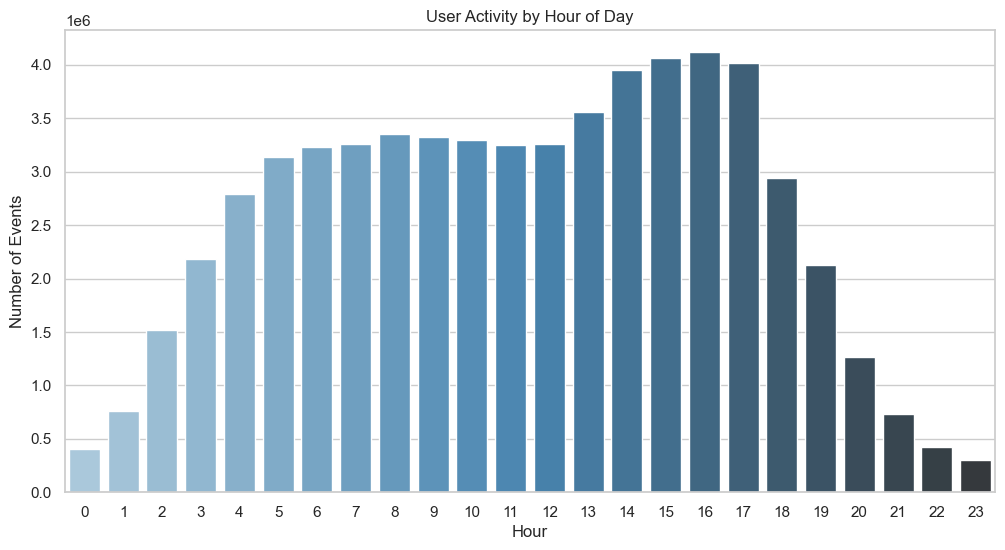

C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3103220171.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette="Greens_d")


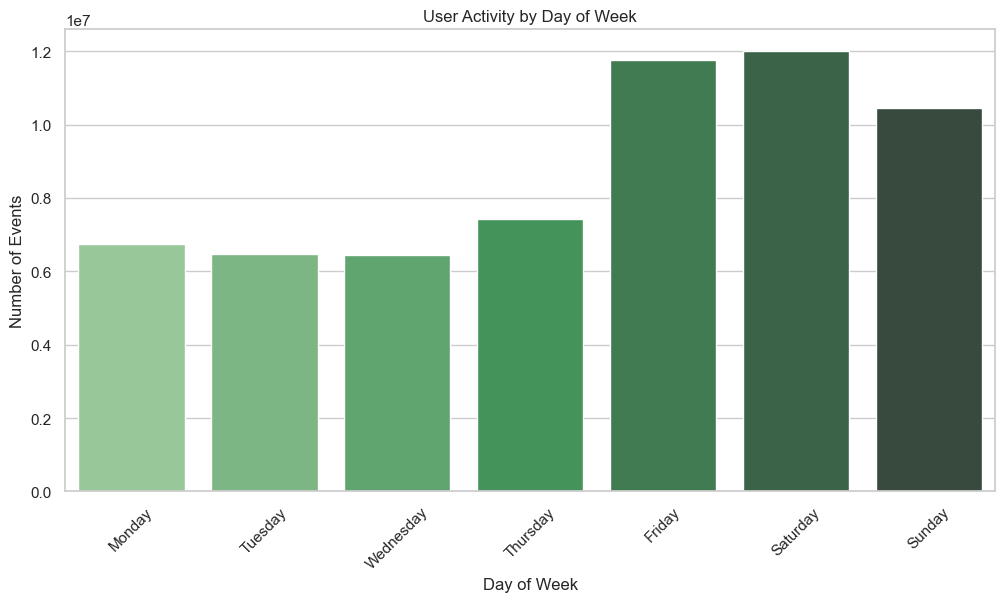

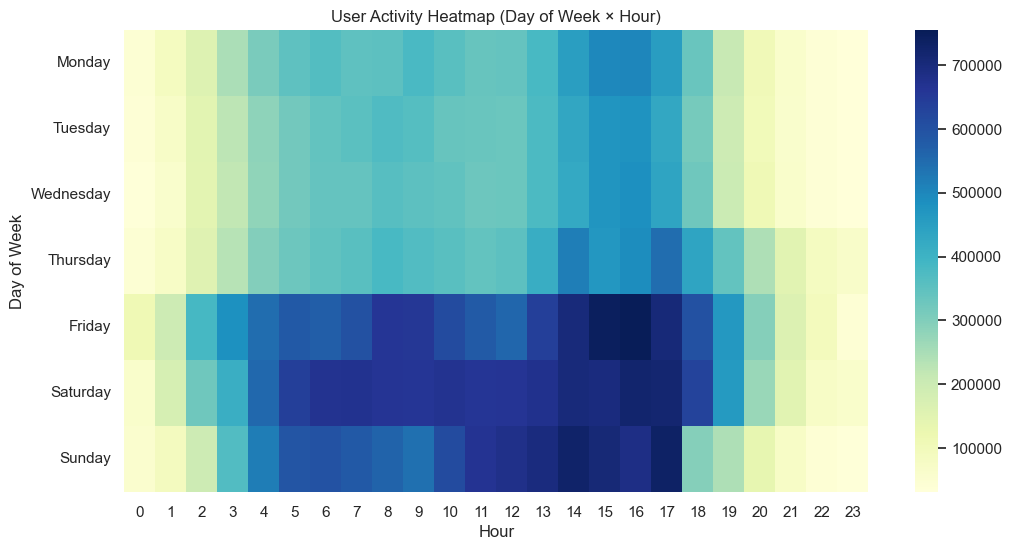

In [5]:
# =======================
# TIME-BASED ANALYSIS
# =======================

import numpy as np

# 1. Activity by hour
hourly_counts = df['hour'].value_counts().sort_index()

sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="Blues_d")
plt.title("User Activity by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Events")
plt.show()

# 2. Activity by day of week (order: Monday -> Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)

sns.barplot(x=day_counts.index, y=day_counts.values, palette="Greens_d")
plt.title("User Activity by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()

# 3. Heatmap: Day of week × Hour
# Pivot table: rows = day_of_week, columns = hour
heatmap_data = df.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='count').reindex(day_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="YlGnBu")
plt.title("User Activity Heatmap (Day of Week × Hour)")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()

# 4. Group data without creating an intermediate huge DataFrame
heatmap_event = (
    df.groupby(['event_type', 'day_of_week', 'hour'])
    .size()
    .reset_index(name='count')
)



Unknown categories: 34.50% of all events


C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3031454626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="mako")


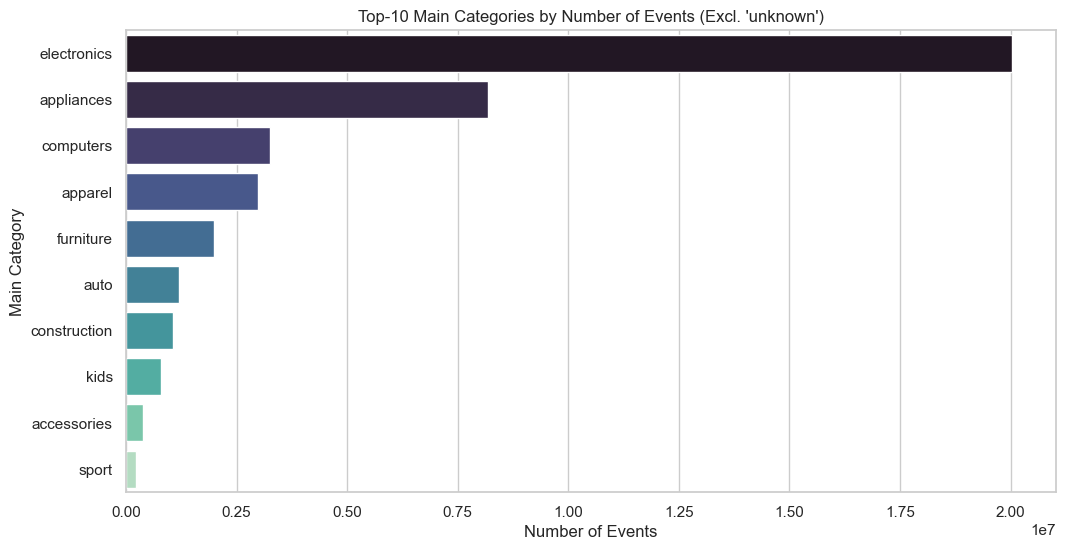

C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3031454626.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette="crest")


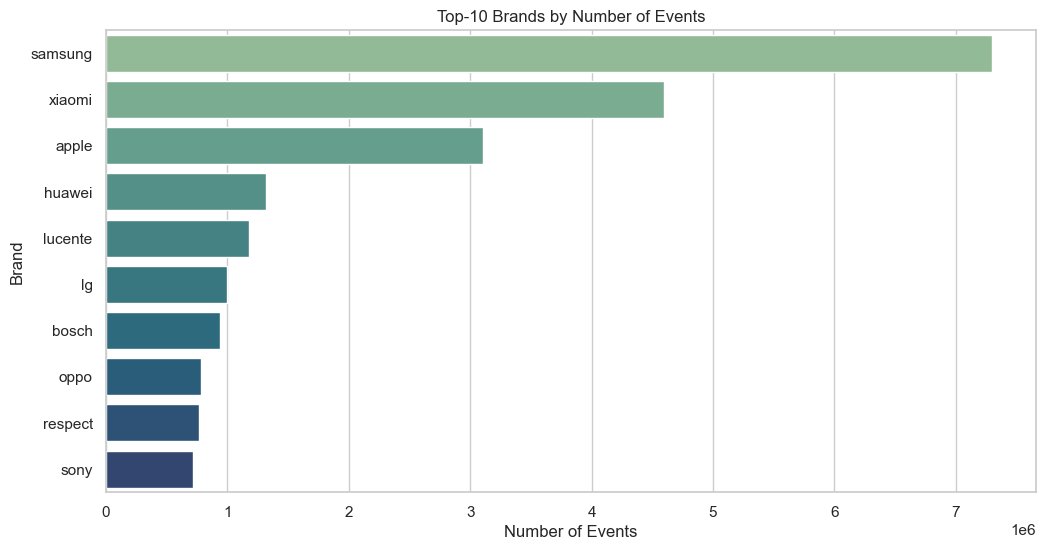

C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3031454626.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_per_cat.values, y=avg_price_per_cat.index, palette="viridis")


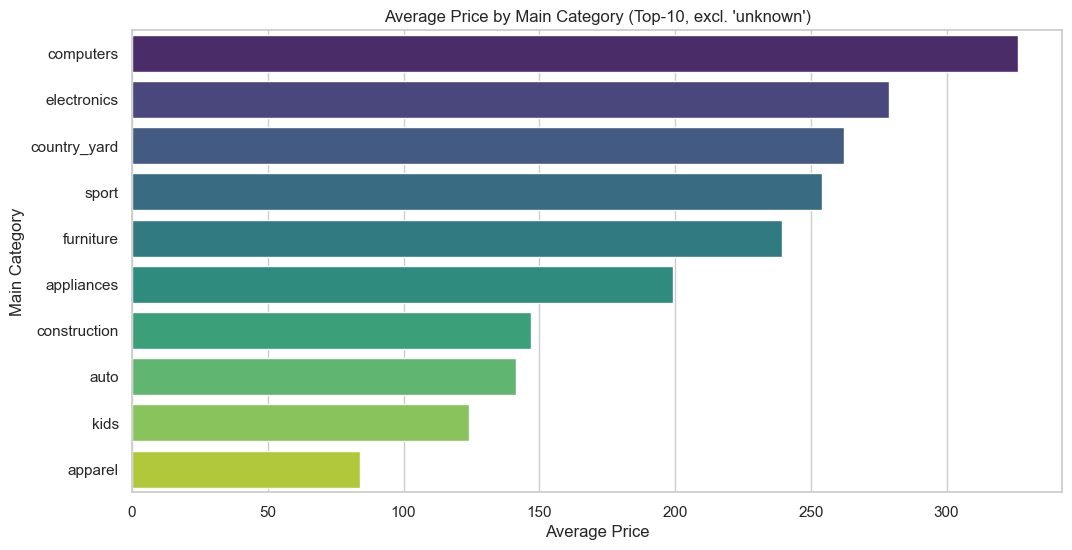

C:\Users\Oughtteaugh\AppData\Local\Temp\ipykernel_19152\3031454626.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='main_category', y='price', data=df_top5, palette="Set2")


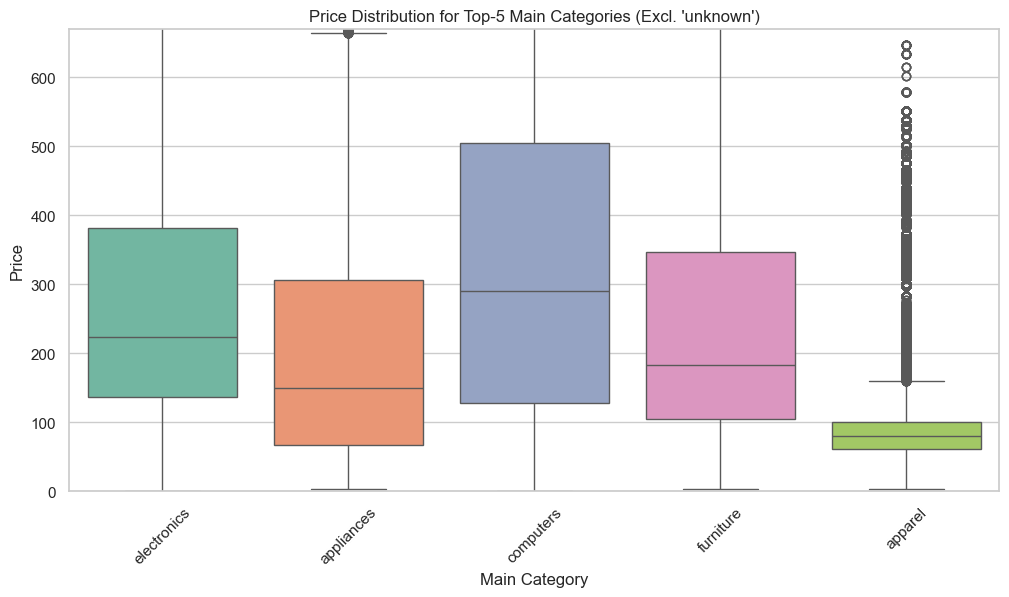

In [8]:
# =======================
# CATEGORY & BRAND ANALYSIS
# =======================

# 0. Calculate percentage of 'unknown' categories
unknown_percent = (df['main_category'] == 'unknown').mean() * 100
print(f"Unknown categories: {unknown_percent:.2f}% of all events")

# 1. Top-10 main categories excluding 'unknown'
top_categories = df[df['main_category'] != 'unknown']['main_category'].value_counts().head(10)

sns.barplot(x=top_categories.values, y=top_categories.index, palette="mako")
plt.title("Top-10 Main Categories by Number of Events (Excl. 'unknown')")
plt.xlabel("Number of Events")
plt.ylabel("Main Category")
plt.show()

# 2. Top-10 brands by number of events
top_brands = df['brand'].value_counts().drop('nan', errors='ignore').head(10)

sns.barplot(x=top_brands.values, y=top_brands.index, palette="crest")
plt.title("Top-10 Brands by Number of Events")
plt.xlabel("Number of Events")
plt.ylabel("Brand")
plt.show()

# 3. Average price per main category excluding 'unknown'
avg_price_per_cat = (
    df[df['main_category'] != 'unknown']
    .groupby('main_category')['price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

sns.barplot(x=avg_price_per_cat.values, y=avg_price_per_cat.index, palette="viridis")
plt.title("Average Price by Main Category (Top-10, excl. 'unknown')")
plt.xlabel("Average Price")
plt.ylabel("Main Category")
plt.show()

# 4. Boxplot of prices for top-5 categories excluding 'unknown'
top5_cats = top_categories.index[:5]
df_top5 = df[df['main_category'].isin(top5_cats)]

sns.boxplot(x='main_category', y='price', data=df_top5, palette="Set2")
plt.title("Price Distribution for Top-5 Main Categories (Excl. 'unknown')")
plt.xlabel("Main Category")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.ylim(0, df_top5['price'].quantile(0.95))  # limit to avoid extreme outliers
plt.show()



In [10]:
# =======================
# CONVERSION FUNNEL
# =======================

# 1. Count unique users at each step
funnel_counts = df.groupby('event_type')['user_id'].nunique()
funnel_counts = funnel_counts[['view', 'cart', 'purchase']]  # ensure correct order

print("Unique users at each step:")
print(funnel_counts)

# 2. Calculate conversion rates
view_to_cart = (funnel_counts['cart'] / funnel_counts['view']) * 100
cart_to_purchase = (funnel_counts['purchase'] / funnel_counts['cart']) * 100
overall_conversion = (funnel_counts['purchase'] / funnel_counts['view']) * 100

print(f"\nView → Cart: {view_to_cart:.2f}%")
print(f"Cart → Purchase: {cart_to_purchase:.2f}%")
print(f"Overall View → Purchase: {overall_conversion:.2f}%")

# 3. Plot funnel
!pip install plotly
import plotly.express as px

funnel_df = funnel_counts.reset_index()
funnel_df.columns = ['Stage', 'Users']

fig = px.funnel(funnel_df, x='Users', y='Stage', title='E-commerce Conversion Funnel')
fig.show()


Unique users at each step:
event_type
view        3528161
cart         767234
purchase     411345
Name: user_id, dtype: int64

View → Cart: 21.75%
Cart → Purchase: 53.61%
Overall View → Purchase: 11.66%
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.6 MB 4.5 MB/s eta 0:00:02
   -------------- ------------------------- 3.4/9.6 MB 7.9 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.6 MB 9.2 MB/s eta 0:00:01
   ------------------------------ --------- 7.3/9.6 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 9.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
